In [1]:
# PYTHON IMPORTS
import os, copy
from tqdm.notebook import trange, tqdm

# IMAGE IMPORTS 
from PIL import Image
import cv2
import tifffile

# DATA IMPORTS 
import random, h5py
import numpy as np

# PLOTTING
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# NEURAL NETWORK
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.transforms import ToPILImage, GaussianBlur
from torchvision.transforms import Compose, RandomCrop, ToTensor, Normalize
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# MY OWN CLASSES
from RLNN import *
from DataUtils import * 
from PlottingUtils import *

Image.MAX_IMAGE_PIXELS = 933120000
verbose_level = 0
%matplotlib notebook

In [2]:
base_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data"

input_folder        = f"{base_dir}/CLNN/in"
val_folder          = f"{base_dir}/CLNN/val"
train_target_folder = f"{base_dir}/CLNN/out"
val_target_folder   = f"{base_dir}/CLNN/val_out"
batch_size      = 2
processing_size = 1024

transform = transforms.Compose([
    RandomScaleTransform(0.5, 1, 0.5, 1),
    transforms.RandomRotation(degrees=15, expand=True, fill=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Resize((processing_size, processing_size)),
])

input_only_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25),
    transforms.GaussianBlur((3,3), (0.001, 66))
])

tensor = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = NN_Multiclass(input_folder, train_target_folder, transform=transform, 
                                         crop=False, 
                                         resize=True,
                                         resize_def=processing_size,
                                         input_only_transform=input_only_transform, 
                                        )
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

val_dataset   = NN_Multiclass(val_folder, val_target_folder, transform=transform, 
                                         crop=False, 
                                         resize=True,
                                         resize_def=processing_size,
                                         input_only_transform=input_only_transform,
                                        )

val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=0)

loaders = {'train' : train_loader, "test" : val_loader }

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
def notify(mess, level=4):
    if verbose_level >= level:
        print(mess)

def saveImages(prob_img_or, outputs, filenames, minputs, outputs_folder, rep_id, labels):
    
    # IF FOR SOME REASON OUTPUT IS UNBATCHED, BATCH IT
    if prob_img_or.ndim == 3:
        prob_img_or = prob_img_or.unsqueeze(0)
        
    # CONVERT TO NUMPY ARRAY
    prob_img_or = prob_img_or.numpy()
    
    # FOR EACH BATCHED OUTPUT
    for i in range(len(outputs)):
        try:
            filename = filenames[i]

            # CONVERT TO IMAGE NUMPY ARRAY
            prob_img = prob_img_or[i, :, :, :]
            prob_img = (prob_img * 255).astype(np.uint8) 

            # SAVE TO FILE
            tifffile.imsave(os.path.join(outputs_folder, f"{rep_id}_{filename[:-4]}_out.tiff"), prob_img)

            # SAVE INPUTS
            myinp = Image.fromarray(np.uint8(minputs[i, 0, :, :] * 255))
            myinp.save(os.path.join(outputs_folder, f"{rep_id}_{filename[:-4]}_inp.png"))

            # SAVE OUTPUTS
            mylab = Image.fromarray(np.uint8(labels[i, :, :] * 255))
            mylab.save(os.path.join(outputs_folder, f"{rep_id}_{filename[:-4]}_lab.png"))
        except:
            continue
            
def train(model, dataloaders, num_epochs=50, 
          output_dir=f'{base_dir}/CLNN/intermediate_outputs_1', 
          learning_rate=5e-4,
          device = torch.device("cuda:0"),
          continue_from=None,
          weights=[1, 2]):
    
    # TRAINING PARAMETERS
    weights = torch.tensor(weights).float().to(device)
    criterion = nn.CrossEntropyLoss(weight=weights, reduction="mean")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)
    start_epoch = 0
        
    if continue_from is not None:
        checkpoint = torch.load(continue_from)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
        for g in optimizer.param_groups:
            g['lr'] = learning_rate
        start_epoch = checkpoint['epoch']
        start_loss = checkpoint['loss']
        
    # SEND MODEL TO GPU
    model = model.to(device)
    
    # MAKE SURE DIRS FOR TEMP OUTPUTS EXIST
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # STRUCTURES FOR PLOTTING
    epoch_losses = {'train' : [], 'test' : []}
    iou_lists    = {'train' : [], 'test' : []}
    lr_list      = []
    fig, axs = init_plotting()
        
    # LOOP THROUGH EPOCHS
    for epoch in range(start_epoch, num_epochs):
        notify('Epoch {}/{}'.format(epoch+1, num_epochs), level=1)
        notify('-' * 10, level=1)
        phases = ['train', 'test']
        epoch_loss = {'train' : 0, 'test' : 0}
        iou_list = {'train' : [], 'test' : []}      
        
        # FOR BOTH PHASES
        for phase in phases: 
            if phase == 'train':
                model.train()
                repeats = range(4)
            else:
                model.eval()
                repeats = range(1)
            
            # MAKE DIR FOR CURRENT PHASE IF IT DOES NOT EXIST
            outputs_folder = os.path.join(output_dir, phase)
            if not os.path.exists(outputs_folder):
                os.makedirs(outputs_folder)
                
            # BASELINE MEMORY USAGE                
            notify(f"Prior to Iterations\t {torch.cuda.memory_allocated() / 1e6}")
            
            # COUNT HOW MANY IMAGES
            n_images = 0
            
            # ITERATE OVER REPEATS
            for rep_id in tqdm(repeats, disable=verbose_level < 4):
                for inputs, labels, filenames in dataloaders[phase]:
                    
                    # SEND TO GPU
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    notify(f"Datasets Moved\t\t {torch.cuda.memory_allocated()/ 1e6}")
                    
                    # ZERO GRADIENTS AND THROUGH MODEL
                    optimizer.zero_grad()
                    outputs = model(inputs, resize=False)
                    
                    notify(f"Outputs Processed\t {torch.cuda.memory_allocated() / 1e6}")
                    
                    # CALCULATE LOSS AND KEEP TRACK OF IT FOR CURRENT EPOCH
                    loss = criterion(outputs, labels) 
                    epoch_loss[phase] += loss
                    iou_list[phase].append(calculate_iou(outputs, labels).detach().cpu().numpy())
                    notify(f"Loss Calculated\t\t {torch.cuda.memory_allocated() / 1e6}")
                    
                    # COUNT HOW MANY IMAGES
                    n_images += inputs.shape[0]
                    
                    # OPTIMIZE IF PHASE IS TRAINING
                    if phase is 'train':
                        notify("Optimizing")
                        loss.backward()
                        optimizer.step()
                        notify(f"Backwards and optimized\t {torch.cuda.memory_allocated() / 1e6}")
                    
                    # SAVE TRAINING IMAGES IF CURRENT STEP REQUIRES IT
                    if rep_id % 2 == 0 and rep_id != 0:
                        prob_img_or = outputs.detach().cpu()
                        minputs     = inputs.detach().cpu().numpy()
                        mlabels     = labels.detach().cpu().numpy()
                        saveImages(prob_img_or, outputs, filenames, minputs, outputs_folder, rep_id, mlabels)
                    
                    # EMPTY CACHE
                    torch.cuda.empty_cache()
                    notify(f"Cache Emptied\t\t {torch.cuda.memory_allocated() / 1e6}")
                    
            # METRICS - NORMALIZE EPOCH LOSS AND IOU BY HOW MANY IMAGES
            epoch_loss[phase] = epoch_loss[phase].cpu().detach().numpy() / (len(repeats) + n_images)
            iou_list[phase]   = np.mean(np.vstack(iou_list[phase]), axis=0)
        
        # UPDATE LEARNING RATE SCHEDULER
        lr_list.append(learning_rate_scheduler.get_lr()[0])
        learning_rate_scheduler.step()
        
        # PLOT, FIRST BY TRANSFERING TO LISTS
        for i in phases:
            epoch_losses[i].append(epoch_loss[i])
            iou_lists[i].append(iou_list[i])
        
        update_plots([epoch_losses[i] for i in phases], [iou_lists[i] for i in phases], fig, axs, 
                     colors=["r", "g", "b", "k", "orange"]*2,
                     annotations=f"Learning Rate: {lr_list[-1]:.2e}"
                    )
        
        # SAVE MODEL EVERY TEN EPOCHS
        if epoch % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'iou_lists' : iou_lists,
                'epoch_losses' : epoch_losses,
                'lr_list' : lr_list
            }, f'{base_dir}/CLNN/checkpoint_101223.pth')
            
            torch.save(model, f"{base_dir}/CLNN/checkpoint_101223.pth")
        
    return model

C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<IPython.core.display.Javascript object>


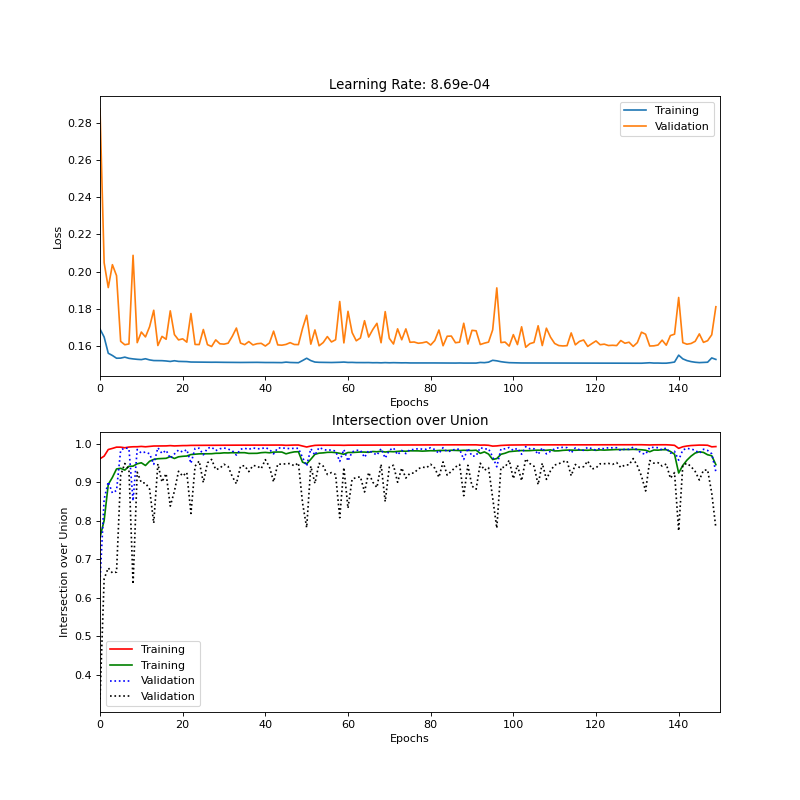

C:\Users\fhacesga\Desktop\FIRMsDigitizing\RECTDNN\RLNN.py:130: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)
C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


In [4]:
model = RLNN(finalpadding=1, num_classes=2, verbose_level=verbose_level)
model = train(model, loaders, num_epochs=2500, learning_rate=1e-3,
             continue_from=f'{base_dir}/CLNN/checkpoint_101123.pth')